In [77]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import random
import re

import transformers
from transformers import logging

logging.set_verbosity_error()

# DEVICE
device = torch.device("cpu")

In [78]:
f = open('data/data.json')
data = json.load(f)

In [79]:
# The dataset I've created
df = pd.read_csv('data/chat_train.csv')
df.head()

,text,label
0,What time of day is it,date
1,What day is it?,date
2,What is the month,date
3,How is Sunday going,date
4,I have to sign off,goodbye


In [80]:
df['label'].value_counts()

greeting    16
age         10
name         7
date         7
goodbye      7
Name: label, dtype: int64

In [81]:
# Encoding the labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
# Checking distribution
df['label'].value_counts(normalize = True)

3    0.333333
0    0.208333
4    0.145833
2    0.145833
1    0.145833
5    0.020833
Name: label, dtype: float64

In [82]:
train_text, train_labels = df['text'], df['label']

In [83]:
# bert-base-uncased model

# from transformers import AutoModel, BertTokenizerFast
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# bert = AutoModel.from_pretrained('bert-base-uncased')

In [84]:
# roberta-base model

# from transformers import RobertaTokenizer, RobertaModel
# # Load the Roberta tokenizer
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# # Import Roberta pretrained model
# bert = RobertaModel.from_pretrained('roberta-base')

In [124]:
# distilbert-base-uncased model

from transformers import DistilBertTokenizer, DistilBertModel
# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Import pretrained model
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [125]:
text = ["this is a bert model.", "some test sentence"]
# Encode the text
encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
print(encoded_input)

{'input_ids': tensor([[  101,  2023,  2003,  1037, 14324,  2944,  1012,   102],
        [  101,  2070,  3231,  6251,   102,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0]])}


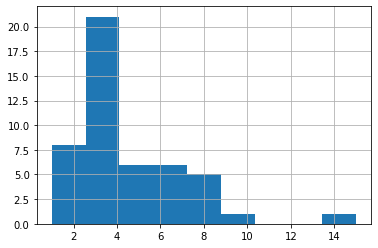

In [126]:
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 9)
# Based on the histogram we select max sequence length as 9
max_seq_len = 9

In [127]:
# Tokenization of the sequences in train data
tokens_train = tokenizer(
    train_text.tolist(),
    max_length = max_seq_len,
    padding='longest',
    truncation=True,
    return_token_type_ids=False
)

In [128]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())


In [129]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_data = TensorDataset(train_seq, train_mask, train_y)

train_sampler = RandomSampler(train_data)

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


In [130]:
class BERT(nn.Module):
    
    def __init__(self, bert):      
        super(BERT, self).__init__()
        self.bert = bert 
        
        # Dropout layer
        self.dropout = nn.Dropout(0.2)
        
        # Activation
        self.relu =  nn.ReLU()
    
        # Dense layer
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,6)
    
        # Softmax activation
        self.softmax = nn.LogSoftmax(dim=1)
        
    # Forward pass for Torch
    def forward(self, sent_id, mask):
    
        # Fully connected
        x = self.bert(sent_id, attention_mask=mask)[0][:,0]
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Output layer
        x = self.fc3(x)
        
        # Apply softmax
        x = self.softmax(x)
        return x
    

In [131]:
# Pevent model weights update for fine-tuning.
for param in bert.parameters():
      param.requires_grad = False
        
model = BERT(bert)

# Load the model into device 
model = model.to(device)
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BERT                                                    --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linear: 1-4                                           393,728
├─Linear: 1-5                                           131,328
├─Linear: 1-6                                           1,542
├─LogSoftmax: 1-7                                       --
Total 

In [132]:
# AdamW optimizer

from transformers import AdamW
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr = 1e-3)


In [133]:
from sklearn.utils.class_weight import compute_class_weight
# Computation of the class weights
class_weights = compute_class_weight( class_weight='balanced',
                                  classes=np.unique(train_labels),
                                  y=train_labels )
print(class_weights)


[0.8        1.14285714 1.14285714 0.5        1.14285714 8.        ]


In [134]:
# Class weights to tensor
weights= torch.tensor(class_weights, dtype=torch.float)
weights = weights.to(device)

# Loss function: Negative log-likelihood
cross_entropy = nn.NLLLoss(weight=weights)


In [135]:
from torch.optim.lr_scheduler import StepLR

train_losses=[]

# n epochs
n_epochs = 200

# learning rate scheduler to improve results
step_lr_sscheduler = StepLR(optimizer, step_size=100, gamma=0.1)


In [136]:
# Model training
def train():
    
    model.train()
    total_loss = 0
    
    total_predictions=[]

    for step, batch in enumerate(train_dataloader):

        # Load the batch into device
        batch = [r.to(device) for r in batch] 
        sent_id, mask, labels = batch
        
        # Get model predictions for the current batch
        predictions = model(sent_id, mask)
        
        # Loss between actual and predicted labels
        loss = cross_entropy(predictions, labels)
        
        # Add on to the total loss
        total_loss =+ loss.item()
        
        # Backward propagation for gradient calculation
        loss.backward()
        
        # Upper bounding the the gradients to 1.0 to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Predictions usually stored in the GPU (however I use CPU as well). We load onto CPU anyway.
        predictions=predictions.detach().cpu().numpy()
        
        # Save predictions of the batch
        total_predictions.append(predictions)
        
    # Training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
      
    # Predictions -> (n batches, batch_size, n classes)
    # Reshape predictions into -> (n samples, n classes)
    total_predictions  = np.concatenate(total_predictions, axis=0)
    
    # Return average loss and predictions
    return avg_loss, total_predictions


In [137]:
for epoch in range(n_epochs):
     
    print('\n Epoch {:} / {:} \r'.format(epoch + 1, n_epochs))
    
    # Train model
    train_loss, _ = train()
    
    # Save training and validation loss
    train_losses.append(train_loss)
    
    # Deterministicity for reproducibility of the train process for further needs
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
print(f'\nLoss: {train_loss:.3f}\r')


 Epoch 1 / 200 

 Epoch 2 / 200 

 Epoch 3 / 200 

 Epoch 4 / 200 

 Epoch 5 / 200 

 Epoch 6 / 200 

 Epoch 7 / 200 

 Epoch 8 / 200 

 Epoch 9 / 200 

 Epoch 10 / 200 

 Epoch 11 / 200 

 Epoch 12 / 200 

 Epoch 13 / 200 

 Epoch 14 / 200 

 Epoch 15 / 200 

 Epoch 16 / 200 

 Epoch 17 / 200 

 Epoch 18 / 200 

 Epoch 19 / 200 

 Epoch 20 / 200 

 Epoch 21 / 200 

 Epoch 22 / 200 

 Epoch 23 / 200 

 Epoch 24 / 200 

 Epoch 25 / 200 

 Epoch 26 / 200 

 Epoch 27 / 200 

 Epoch 28 / 200 

 Epoch 29 / 200 

 Epoch 30 / 200 

 Epoch 31 / 200 

 Epoch 32 / 200 

 Epoch 33 / 200 

 Epoch 34 / 200 

 Epoch 35 / 200 

 Epoch 36 / 200 

 Epoch 37 / 200 

 Epoch 38 / 200 

 Epoch 39 / 200 

 Epoch 40 / 200 

 Epoch 41 / 200 

 Epoch 42 / 200 

 Epoch 43 / 200 

 Epoch 44 / 200 

 Epoch 45 / 200 

 Epoch 46 / 200 

 Epoch 47 / 200 

 Epoch 48 / 200 

 Epoch 49 / 200 

 Epoch 50 / 200 

 Epoch 51 / 200 

 Epoch 52 / 200 

 Epoch 53 / 200 

 Epoch 54 / 200 

 Epoch 55 / 200 

 Epoch 56 / 200 



In [138]:
def get_prediction(strin):
    
    strin = re.sub(r'[^a-zA-Z ]+', '', strin)
    test_text = [strin]
    model.eval()
    
    tokens_test_data = tokenizer(
    test_text,
    max_length = max_seq_len,
    padding='longest',
    truncation=True,
    return_token_type_ids=False
    )
    test_seq = torch.tensor(tokens_test_data['input_ids'])
    test_mask = torch.tensor(tokens_test_data['attention_mask'])
    
    predictions = None
    with torch.no_grad():
      predictions = model(test_seq.to(device), test_mask.to(device))
    
    predictions = predictions.detach().cpu().numpy()
    predictions = np.argmax(predictions, axis = 1)
    print('Intent:', le.inverse_transform(predictions)[0])

    # Return decoded labels
    return le.inverse_transform(predictions)[0]


def bot_response(message):
    
  result = ''
  intent = get_prediction(message)
    
  for i in data['intents']:
    if i['tag'] == intent:
        result = random.choice(i['responses'])
        break

  print(f"Response : {result}")
  #return result

In [139]:
bot_response('Hello bot')

Intent: greeting
Response : Hello


In [140]:
bot_response('Great, how are you?')

Intent: greeting
Response : How are you doing?


In [141]:
bot_response('what is your name')

Intent: name
Response : BOTTT


In [142]:
bot_response('What time is it?')

Intent: date
Response : I am available all day


In [143]:
bot_response('Farewell!!')

Intent: goodbye
Response : Best regards.
